In [95]:
from spreg import OLS, vif, OLS_Regimes
import pysal as ps
import libpysal
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from tobler.area_weighted import area_join, area_interpolate
from pysal.explore import esda
import contextily
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.impute import KNNImputer
from sklearn.metrics import r2_score

In [98]:
# Load regression gds 
selected = gpd.read_file('../YouthInTheCity/data/regression_gdf.shp')


# Select features manually
selected.drop(columns=['HK_EU15', 'HK_EU28', 'HK_Polen', 'HK_EheJug', 'HK_EheSU', 'HK_Turk',
       'HK_Arab', 'HK_Sonst', 'HK_NZOrd','dyn_ew','vegpm10','BZR_NAME',
       'change','sp_nee_sch', 'noise','green', 'dyn_sales','schools','kindergart'], inplace=True)

# Export it as shapefile
selected.to_file('../raw_data/basic_model_preds_gdf.shp', mode="w")

# Load it again
selected = gpd.read_file('../raw_data/basic_model_preds_gdf.shp')

In [99]:
selected.columns

Index(['PLR_ID', 'public_tra', 'eating', 'culture', 'community', 'health_car',
       'public_ser', 'education', 'universiti', 'outdoor_fa', 'outdoor_le',
       'night_life', 'water', 'mig_rate', 'ave_rent', 'social_hou',
       'public_hou', 'five_y_pls', 'child_pov', 'dyn_unempl', 'air', 'bio',
       'vegpm20', 'ch_rate', 'other_sch', 'vocat_sch', 'primary_sc',
       'Gymnasium', 'secon_sch', 'priv_schoo', 'kita', 'stations', 'geometry'],
      dtype='object')

In [100]:
# loading dbf
db = libpysal.io.open('../raw_data/basic_model_preds_gdf.dbf','r')

# computing spatial weights
queen = libpysal.weights.Queen.from_dataframe(selected)
inv_dist = libpysal.weights.DistanceBand.from_dataframe(selected, 5000, geom_col='geometry', binary=False)
rook = libpysal.weights.Rook.from_dataframe(selected)

In [101]:
corr = selected.corr()
corr_df = corr.unstack().reset_index() #Unstack correlation matrix
corr_df.columns = ["feature_1", "feature_2", "correlation"] #Rename the columns
corr_df.sort_values(by="correlation", ascending=False, inplace=True)
corr_df = corr_df[corr_df["feature_1"] != corr_df["feature_2"]] #remove the self-corr
corr_df.head(20)

,feature_1,feature_2,correlation
354,night_life,eating,0.862194
75,eating,night_life,0.862194
98,culture,eating,0.839034
67,eating,culture,0.839034
107,culture,night_life,0.806965
355,night_life,culture,0.806965
971,kita,night_life,0.783679
382,night_life,kita,0.783679
356,night_life,community,0.771060
139,community,night_life,0.771060


In [73]:
y = np.array(selected['child_pov'])
X = selected.drop(columns=[
    'PLR_ID','child_pov', 'geometry']).to_numpy()

In [53]:
selected.columns

Index(['PLR_ID', 'public_tra', 'eating', 'culture', 'community', 'health_car',
       'public_ser', 'education', 'universiti', 'outdoor_fa', 'outdoor_le',
       'night_life', 'water', 'mig_rate', 'ave_rent', 'social_hou',
       'public_hou', 'five_y_pls', 'child_pov', 'dyn_unempl', 'air', 'bio',
       'vegpm20', 'ch_rate', 'other_sch', 'vocat_sch', 'primary_sc',
       'Gymnasium', 'secon_sch', 'priv_schoo', 'kita', 'stations', 'geometry'],
      dtype='object')

In [74]:
columns = [
        'public_tra', 'eating', 'culture', 'community', 'health_car',
        'public_ser', 'education', 'universiti', 'outdoor_fa', 'outdoor_le',
        'night_life', 'water', 'mig_rate', 'ave_rent', 'social_hou',
        'public_hou', 'five_y_pls', 'dyn_unempl',
        'air', 'bio', 'vegpm20', 'ch_rate', 'other_sch', 'vocat_sch',
        'primary_sc', 'Gymnasium', 'secon_sch', 'priv_schoo', 'kita',
        'stations'
]

In [55]:
m1 = OLS(y,
        X,
        w=inv_dist,
        name_y='child_pov',
        name_x=columns,
        name_w='dist',
        name_ds='basic_model',
        white_test=True,
        gwk=inv_dist,
        spat_diag=True,
        moran=True)

(array([ 35.,  93., 113.,  96.,  79.,  55.,  33.,  23.,   6.,   3.]),
 array([-2.39568646,  5.20711586, 12.80991819, 20.41272051, 28.01552284,
        35.61832517, 43.22112749, 50.82392982, 58.42673214, 66.02953447,
        73.6323368 ]),
 <BarContainer object of 10 artists>)

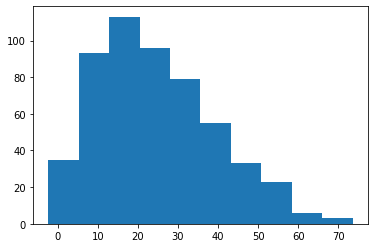

In [56]:
plt.hist(m1.predy.flatten())

<AxesSubplot:>

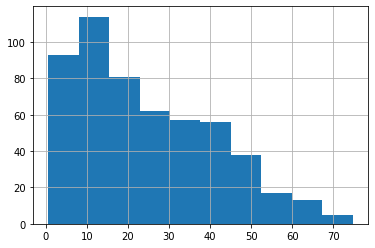

In [57]:
selected['child_pov'].hist()

In [58]:
mae(selected['child_pov'], m1.predy.flatten())

5.608060820469872

In [59]:
np.sqrt(mse(selected['child_pov'], m1.predy.flatten()))

7.650932978669977

In [33]:
print(m1.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            : basic_model
Weights matrix      :        dist
Dependent Variable  :   child_pov                Number of Observations:         536
Mean dependent var  :     24.5406                Number of Variables   :          33
S.D. dependent var  :     16.6701                Degrees of Freedom    :         503
R-squared           :      0.7916
Adjusted R-squared  :      0.7784
Sum squared residual:   30976.569                F-statistic           :     59.7239
Sigma-square        :      61.584                Prob(F-statistic)     :  1.811e-149
S.E. of regression  :       7.848                Log likelihood        :   -1847.787
Sigma-square ML     :      57.792                Akaike info criterion :    3761.575
S.E of regression ML:      7.6021                Schwarz criterion     :    3902.951

-----------------------------------------------------------------------------

In [60]:
# creating vif dataframe

v = vif(m1)
del(v[0])
vif_array = np.array(v, dtype=float)

v_d = pd.DataFrame({'feature': columns, 
                   'vif': vif_array[:,0], 
                   'tolerance':  vif_array[:,1]})

v_d

,feature,vif,tolerance
0,public_tra,2.829917,0.353367
1,eating,12.388951,0.080717
2,culture,5.257767,0.190195
3,community,4.009247,0.249423
4,health_car,2.786075,0.358928
5,public_ser,4.854708,0.205986
6,education,2.498672,0.400213
7,universiti,1.947061,0.513595
8,outdoor_fa,2.196326,0.455306
9,outdoor_le,1.426793,0.700872


<AxesSubplot:>

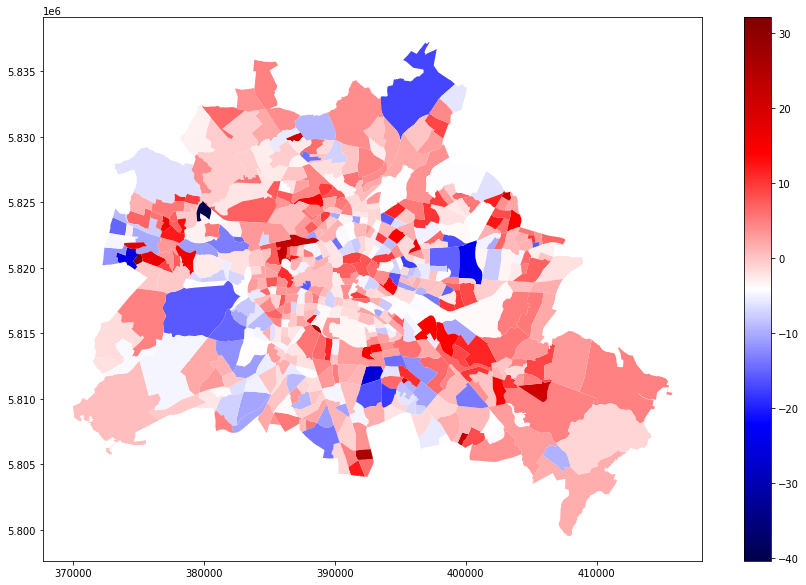

In [83]:
# Adding a resituals column to sample dataframe
res = selected[['PLR_ID', 'geometry']]
res['residuals'] = m1.u

# plotting residuals - red = underestimation, blue = overestimation
res.plot('residuals', figsize=(15,10), cmap= 'seismic', legend=True)

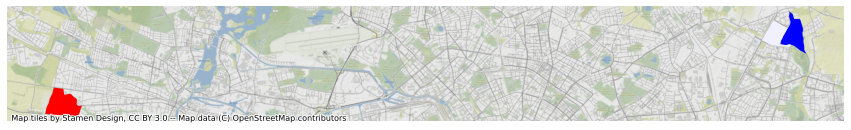

In [62]:
# instantiating knn
knn = libpysal.weights.KNN.from_dataframe(selected, k=5)
# Row standardise weights
knn.transform = "R"
# Run LISA on residuals
outliers = esda.moran.Moran_Local(m1.u, knn, permutations=9999)
# Select only LISA cluster cores
error_clusters = outliers.q % 2 == 1
# Filter out non-significant clusters
error_clusters &= outliers.p_sim <= 0.001
# Add `error_clusters` and `local_I` columns
ax = (
    selected.assign(
        error_clusters=error_clusters,
        local_I=outliers.Is
        # Retain error clusters only
    )
    .query(
        "error_clusters"
        # Sort by I value to largest plot on top
    )
    .sort_values(
        "local_I"
        # Plot I values
    )
    .plot("local_I", cmap="bwr", marker=".", figsize=(15,10))
)
# Add basemap
contextily.add_basemap(ax, crs=selected.crs)
# Remove axes
ax.set_axis_off();

In [78]:
# loading east/west maps
west = gpd.read_file('../raw_data/more_maps/Ortsteile__Berlin_West_EPSG54030.shp')
east = gpd.read_file('../raw_data/more_maps/Ortsteile__Berlin_Ost_EPSG54030.shp')

# adapting projections
east.to_crs(crs='EPSG:25833', inplace=True)
west.to_crs(crs='EPSG:25833', inplace=True)

# dissolving
west = west.dissolve()
east = east.dissolve()

# merging both maps into an eastwest geodataframe
eastwest = east.append(west)

# adding an east column to eastwest geodataframe
eastwest['east'] = eastwest.OBJECTID.map({1:1,
                                             2:0})

eastwest = eastwest[['east','geometry']]

# merging eastwest geodataframe with sample df

selected_east = selected.sjoin_nearest(
    eastwest, how='left').dissolve(
    by='PLR_ID')

selected = selected.merge(selected_east.reset_index()[['PLR_ID','east']], on='PLR_ID')

In [79]:
X.shape

(536, 30)

In [80]:
# Running an OLS Regimes model

m2 = OLS_Regimes(y,
                X,
                w=inv_dist,
                regimes=selected['east'],
                name_y='child_pov',
                name_x=columns,
                name_w='dist',
                name_ds='basic_model',
                white_test=True,
                spat_diag=True,
                moran=True)

In [81]:
print(m2.summary)

REGRESSION
----------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES ESTIMATION - REGIME 0
---------------------------------------------------------------
Data set            : basic_model
Weights matrix      :        dist
Dependent Variable  : 0_child_pov                Number of Observations:         195
Mean dependent var  :     21.2256                Number of Variables   :          31
S.D. dependent var  :     15.2800                Degrees of Freedom    :         164
R-squared           :      0.7675
Adjusted R-squared  :      0.7250
Sum squared residual:   10529.099                F-statistic           :     18.0501
Sigma-square        :      64.202                Prob(F-statistic)     :   6.812e-38
S.E. of regression  :       8.013                Log likelihood        :    -665.611
Sigma-square ML     :      53.995                Akaike info criterion :    1393.221
S.E of regression ML:      7.3482                Schwarz criterion     :    1494.684

--------------------------------

In [67]:
mae(selected.child_pov, m2.predy)

5.3108232133917435

<AxesSubplot:>

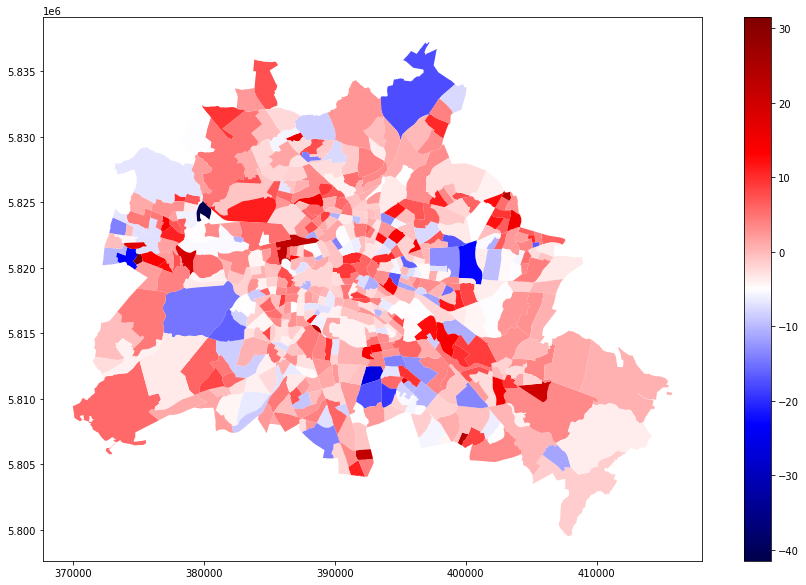

In [84]:
# Adding a resituals column to sample dataframe
res['residuals_m2'] = m2.u

# plotting residuals - red = underestimation, blue = overestimation
res.plot('residuals_m2', figsize=(15,10), cmap= 'seismic', legend=True)

In [53]:
clusters = gpd.read_file('../raw_data/output_maps/2kgdf.shp')

In [62]:
clusters.columns

Index(['PLR_ID', 'public_tra', 'eating', 'community', 'health_car',
       'public_ser', 'education', 'universiti', 'outdoor_fa', 'outdoor_le',
       'water', 'ave_rent', 'social_hou', 'public_hou', 'rent_to_pr',
       'dyn_r_to_p', 'sales', 'dyn_sales', 'child_pov', 'air', 'bio', 'B_1940',
       'B_1941_199', 'B_1991_201', 'vegpm20', 'other_sch', 'vocat_sch',
       'primary_sc', 'Gymnasium', 'secon_sch', 'priv_schoo', 'kita',
       'stations', 'k5cls', 'geometry'],
      dtype='object')

In [ ]:
cluste

In [79]:
columns =['eating', 'public_ser', 'education', 'outdoor_fa', 'outdoor_le', 'ave_rent', 
          'social_hou', 'public_hou', 'rent_to_pr', 'vegpm20','Gymnasium','kita'
         ]

In [81]:
y_c = np.array(clusters['child_pov'])
X_c = clusters.drop(columns=[
    'PLR_ID','child_pov', 'k5cls','public_tra','geometry','dyn_r_to_p','secon_sch', 
    'dyn_sales', 'priv_schoo','other_sch', 'vocat_sch','B_1940','universiti',  'water', 
       'B_1941_199', 'B_1991_201','air', 'community','bio', 'sales',
       'primary_sc']).to_numpy()

In [84]:
# Running an OLS Regimes model

m3 = OLS_Regimes(y_c,
                X_c,
                w=inv_dist,
                regimes=clusters['k5cls'],
                name_y='child_pov',
                name_x=columns,
                name_w='dist',
                name_ds='basic_model',
                white_test=True,
                spat_diag=True,
                moran=True)

In [85]:
print(m3.summary)

REGRESSION
----------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES ESTIMATION - REGIME 0
---------------------------------------------------------------
Data set            : basic_model
Weights matrix      :        dist
Dependent Variable  : 0_child_pov                Number of Observations:         350
Mean dependent var  :     23.9585                Number of Variables   :          15
S.D. dependent var  :     16.2402                Degrees of Freedom    :         335
R-squared           :      0.3603
Adjusted R-squared  :      0.3336
Sum squared residual:   58881.804                F-statistic           :     13.4776
Sigma-square        :     175.767                Prob(F-statistic)     :   2.565e-25
S.E. of regression  :      13.258                Log likelihood        :   -1393.565
Sigma-square ML     :     168.234                Akaike info criterion :    2817.131
S.E of regression ML:     12.9705                Schwarz criterion     :    2875.000

--------------------------------

In [89]:
mae(clusters.child_pov, m3.predy)

9.771951176085265

<AxesSubplot:>

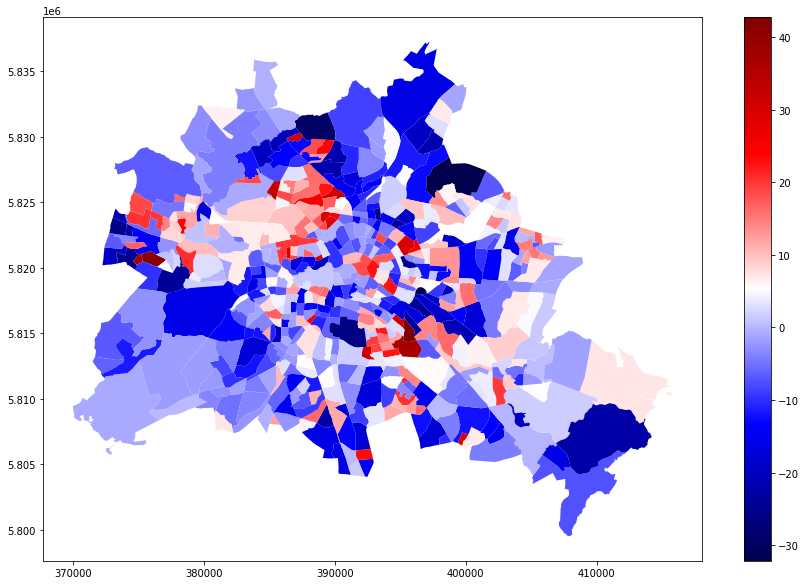

In [88]:
# Adding a resituals column to sample dataframe
clusters['residuals_m3'] = m3.u

# plotting residuals - red = underestimation, blue = overestimation
clusters.plot('residuals_m3', figsize=(15,10), cmap= 'seismic', legend=True)